# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [225]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [226]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [227]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [228]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [229]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [230]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [231]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [232]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [233]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [234]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [235]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [236]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [237]:
original_X = X
original_Y = y 

In [238]:
"""def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)"""

'def shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(original_X, original_Y, seed=65)'

Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6788 - accuracy: 0.5500 - precision_127: 0.5833 - recall_127: 0.3500 - val_loss: 0.7409 - val_accuracy: 0.6000 - val_precision_127: 0.5625 - val_recall_127: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 198ms/step - loss: 0.6477 - accuracy: 0.6625 - precision_127: 0.6327 - recall_127: 0.7750 - val_loss: 0.6449 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5785 - accuracy: 0.7375 - precision_127: 0.7209 - recall_127: 0.7750 - val_loss: 0.5454 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.5884 - accuracy: 0.6875 - precision_127: 0.6471 - recall_127: 0.8250 - val_loss: 0.5711 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000
Epoch 5/75
3/3 [==============================] 

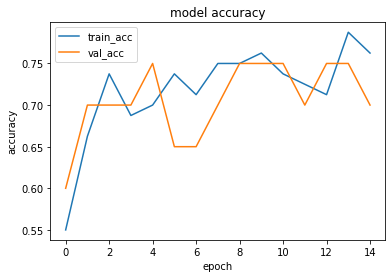

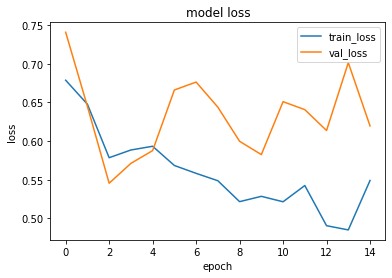

1it [00:00, 16710.37it/s]


prediction for video armflapping_1.mov is [[0.4893412]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.49058858]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.555339]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.43424064]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.391074]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.39519173]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7234 - accuracy: 0.4750 - precision_128: 0.2500 - recall_128: 0.0250 - val_loss: 0.6572 - val_accuracy: 0.5500 - val_precision_128: 0.5263 - val_recall_128: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6978 - accuracy: 0.5000 - precision_128: 0.5000 - recall_128: 1.0000 - val_loss: 0.6207 - val_accuracy: 0.5500 - val_precision_128: 0.5263 - val_recall_128: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6737 - accuracy: 0.5750 - precision_128: 0.5405 - recall_128: 1.0000 - val_loss: 0.6054 - val_accuracy: 0.7500 - val_precision_128: 0.6923 - val_recall_128: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6253 - accuracy: 0.6750 - precision_128: 0.6458 - recall_128: 0.7750 - val_loss: 0.6087 - val_accuracy: 0.7000 - val_precision_128: 0.6667 - val_recall_128: 0.

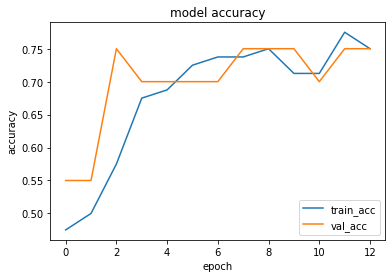

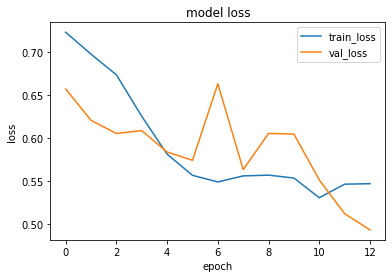

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5233765]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.4593338]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6305646]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.41476074]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.3120829]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.31756923]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.7021 - accuracy: 0.4250 - precision_129: 0.4444 - recall_129: 0.6000 - val_loss: 0.6987 - val_accuracy: 0.7500 - val_precision_129: 0.7778 - val_recall_129: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6217 - accuracy: 0.7375 - precision_129: 0.7317 - recall_129: 0.7500 - val_loss: 0.7267 - val_accuracy: 0.6500 - val_precision_129: 0.6154 - val_recall_129: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5863 - accuracy: 0.6375 - precision_129: 0.5932 - recall_129: 0.8750 - val_loss: 0.7486 - val_accuracy: 0.7500 - val_precision_129: 0.7778 - val_recall_129: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6568 - accuracy: 0.6875 - precision_129: 0.7027 - recall_129: 0.6500 - val_loss: 0.7079 - val_accuracy: 0.6000 - val_precision_129: 0.6000 - val_recall_129: 0.

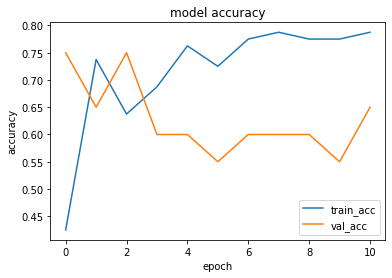

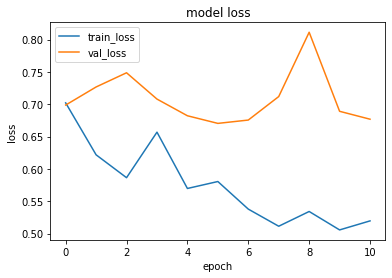

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.33706617]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.28061846]]


1it [00:00, 6213.78it/s]


prediction for video armflapping_2.mov is [[0.48215657]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.29497126]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.28056532]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.2802723]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6811 - accuracy: 0.5375 - precision_130: 0.5429 - recall_130: 0.4750 - val_loss: 0.7225 - val_accuracy: 0.5500 - val_precision_130: 0.5294 - val_recall_130: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6818 - accuracy: 0.6625 - precision_130: 0.6182 - recall_130: 0.8500 - val_loss: 0.5956 - val_accuracy: 0.8000 - val_precision_130: 0.8000 - val_recall_130: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6133 - accuracy: 0.7000 - precision_130: 0.8333 - recall_130: 0.5000 - val_loss: 0.5304 - val_accuracy: 0.7500 - val_precision_130: 0.7273 - val_recall_130: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5771 - accuracy: 0.7500 - precision_130: 0.7273 - recall_130: 0.8000 - val_loss: 0.5758 - val_accuracy: 0.7500 - val_precision_130: 0.6923 - val_recall_130: 0.9

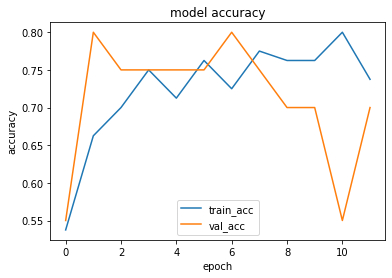

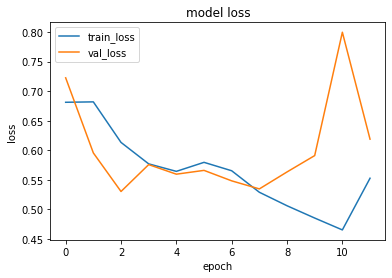

1it [00:00, 6754.11it/s]


prediction for video armflapping_1.mov is [[0.47776908]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5127042]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5082676]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.44976482]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.43583423]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.43361428]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7380 - accuracy: 0.4250 - precision_131: 0.4400 - recall_131: 0.5500 - val_loss: 0.6532 - val_accuracy: 0.6000 - val_precision_131: 0.6250 - val_recall_131: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6901 - accuracy: 0.6000 - precision_131: 0.6667 - recall_131: 0.4000 - val_loss: 0.6356 - val_accuracy: 0.5500 - val_precision_131: 0.5333 - val_recall_131: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6584 - accuracy: 0.5500 - precision_131: 0.5286 - recall_131: 0.9250 - val_loss: 0.6281 - val_accuracy: 0.5500 - val_precision_131: 0.5263 - val_recall_131: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6449 - accuracy: 0.6250 - precision_131: 0.5862 - recall_131: 0.8500 - val_loss: 0.6104 - val_accuracy: 0.7500 - val_precision_131: 0.7273 - val_recall_131: 0.

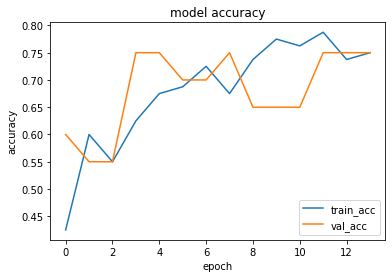

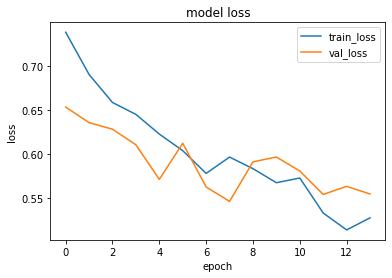

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.59476715]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.6776991]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.7514694]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.18410754]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.16393155]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.1612376]]


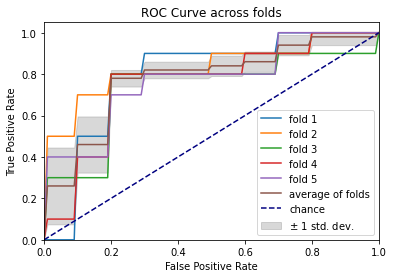

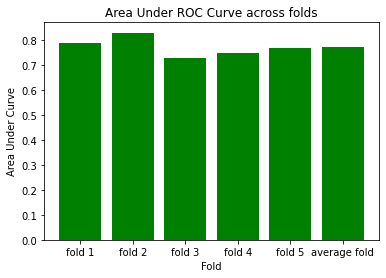

In [239]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6488 - accuracy: 0.6375 - precision_133: 0.6667 - recall_133: 0.5500 - val_loss: 0.9345 - val_accuracy: 0.5000 - val_precision_133: 0.5000 - val_recall_133: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7001 - accuracy: 0.6750 - precision_133: 0.6167 - recall_133: 0.9250 - val_loss: 0.6558 - val_accuracy: 0.6000 - val_precision_133: 0.6667 - val_recall_133: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6266 - accuracy: 0.6750 - precision_133: 0.8500 - recall_133: 0.4250 - val_loss: 0.6425 - val_accuracy: 0.7000 - val_precision_133: 0.6667 - val_recall_133: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5772 - accuracy: 0.7500 - precision_133: 0.7381 - recall_133: 0.7750 - val_loss: 0.6841 - val_accuracy: 0.6500 - val_precision_133: 0.6000 - val_recall_133: 0.9000
Epoch 5/75
3/3 [==============================] 

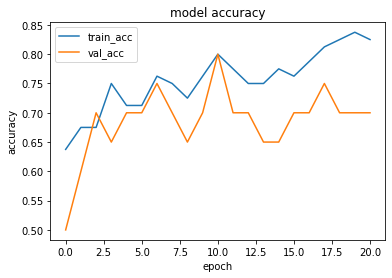

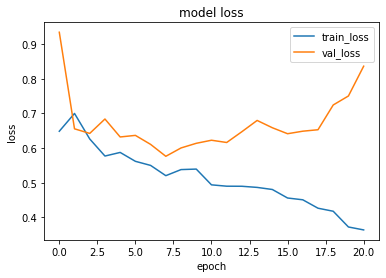

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.5503371]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.6346279]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.66965204]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.42116332]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.3571056]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.3494655]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7223 - accuracy: 0.4625 - precision_134: 0.4727 - recall_134: 0.6500 - val_loss: 0.6795 - val_accuracy: 0.7000 - val_precision_134: 1.0000 - val_recall_134: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6663 - accuracy: 0.5875 - precision_134: 0.7333 - recall_134: 0.2750 - val_loss: 0.6413 - val_accuracy: 0.6500 - val_precision_134: 0.6364 - val_recall_134: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6176 - accuracy: 0.6500 - precision_134: 0.6071 - recall_134: 0.8500 - val_loss: 0.6244 - val_accuracy: 0.6500 - val_precision_134: 0.6364 - val_recall_134: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5693 - accuracy: 0.7500 - precision_134: 0.7273 - recall_134: 0.8000 - val_loss: 0.6189 - val_accuracy: 0.8000 - val_precision_134: 0.8750 - val_recall_134: 0.7

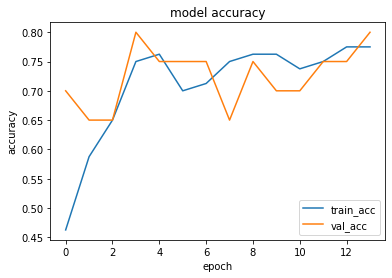

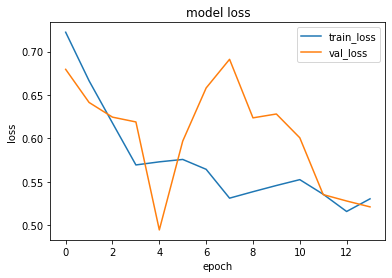

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.51554394]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5917742]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.61960137]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.3172047]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.2727685]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.2701594]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7024 - accuracy: 0.4875 - precision_135: 0.4894 - recall_135: 0.5750 - val_loss: 0.7270 - val_accuracy: 0.5000 - val_precision_135: 0.0000e+00 - val_recall_135: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 195ms/step - loss: 0.6556 - accuracy: 0.6500 - precision_135: 0.7727 - recall_135: 0.4250 - val_loss: 0.6843 - val_accuracy: 0.4500 - val_precision_135: 0.4737 - val_recall_135: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6266 - accuracy: 0.5750 - precision_135: 0.5417 - recall_135: 0.9750 - val_loss: 0.6936 - val_accuracy: 0.4500 - val_precision_135: 0.4737 - val_recall_135: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5858 - accuracy: 0.6625 - precision_135: 0.6182 - recall_135: 0.8500 - val_loss: 0.6974 - val_accuracy: 0.7500 - val_precision_135: 0.7778 - val_recall_

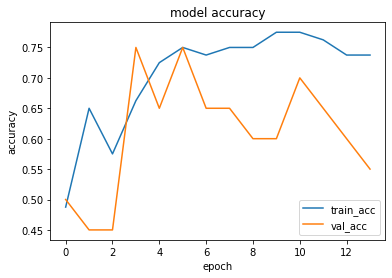

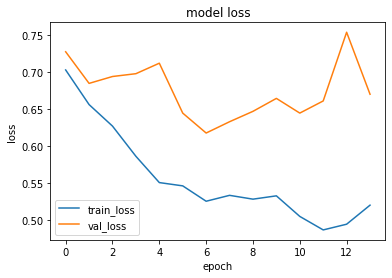

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.29255903]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.42073545]]


1it [00:00, 5269.23it/s]


prediction for video armflapping_2.mov is [[0.50662464]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.22816488]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.21029696]]


1it [00:00, 13486.51it/s]


prediction for video control_3.mov is [[0.19001603]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.7554 - accuracy: 0.5375 - precision_136: 0.5231 - recall_136: 0.8500 - val_loss: 0.6357 - val_accuracy: 0.7000 - val_precision_136: 0.6667 - val_recall_136: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6527 - accuracy: 0.6375 - precision_136: 0.6667 - recall_136: 0.5500 - val_loss: 0.6254 - val_accuracy: 0.6000 - val_precision_136: 0.6667 - val_recall_136: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6344 - accuracy: 0.6625 - precision_136: 0.8095 - recall_136: 0.4250 - val_loss: 0.5981 - val_accuracy: 0.8000 - val_precision_136: 0.8000 - val_recall_136: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6518 - accuracy: 0.6875 - precision_136: 0.6744 - recall_136: 0.7250 - val_loss: 0.5854 - val_accuracy: 0.6500 - val_precision_136: 0.6154 - val_recall_136: 0.

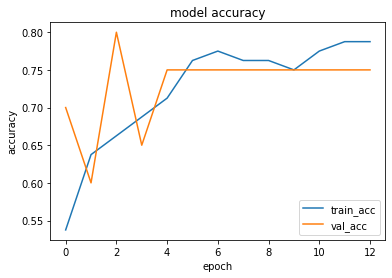

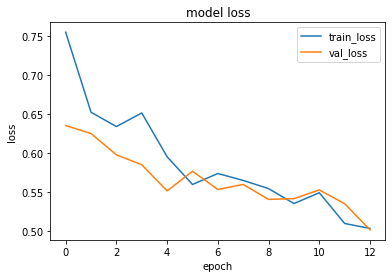

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.313586]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_3.mov is [[0.5476382]]


1it [00:00, 19691.57it/s]


prediction for video armflapping_2.mov is [[0.6860114]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.24907464]]


1it [00:00, 14563.56it/s]


prediction for video control_2.mov is [[0.21404064]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.21076894]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6831 - accuracy: 0.4625 - precision_137: 0.4746 - recall_137: 0.7000 - val_loss: 0.6963 - val_accuracy: 0.5500 - val_precision_137: 0.5263 - val_recall_137: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6256 - accuracy: 0.6250 - precision_137: 0.5806 - recall_137: 0.9000 - val_loss: 0.9635 - val_accuracy: 0.5000 - val_precision_137: 0.0000e+00 - val_recall_137: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6690 - accuracy: 0.6625 - precision_137: 0.7600 - recall_137: 0.4750 - val_loss: 0.6123 - val_accuracy: 0.6500 - val_precision_137: 0.5882 - val_recall_137: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6635 - accuracy: 0.6125 - precision_137: 0.5714 - recall_137: 0.9000 - val_loss: 0.6597 - val_accuracy: 0.6000 - val_precision_137: 0.5556 - val_recall

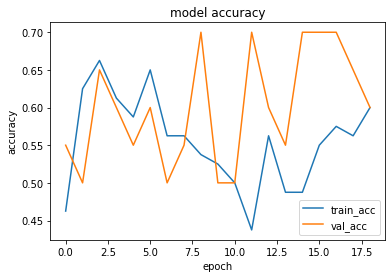

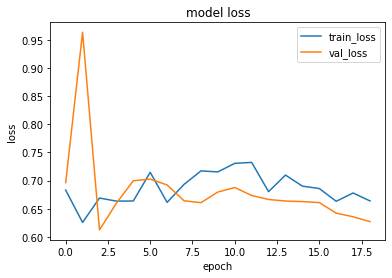

1it [00:00, 11397.57it/s]


prediction for video armflapping_1.mov is [[0.3056405]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.50870234]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.30174938]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.30438054]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.49278882]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.30394208]]


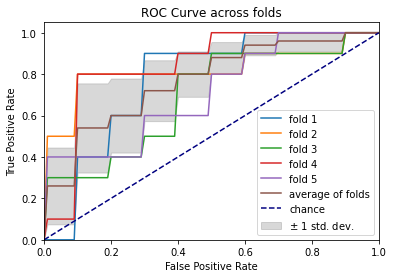

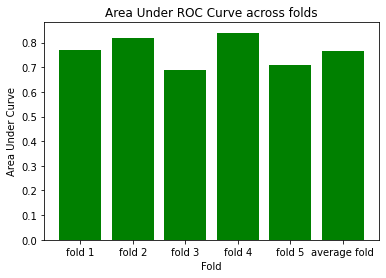

In [240]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6820 - accuracy: 0.5250 - precision_139: 0.5217 - recall_139: 0.6000 - val_loss: 0.6331 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6282 - accuracy: 0.7500 - precision_139: 0.7778 - recall_139: 0.7000 - val_loss: 0.6120 - val_accuracy: 0.7500 - val_precision_139: 0.7273 - val_recall_139: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5849 - accuracy: 0.7125 - precision_139: 0.7742 - recall_139: 0.6000 - val_loss: 0.6050 - val_accuracy: 0.7500 - val_precision_139: 0.6923 - val_recall_139: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5607 - accuracy: 0.7500 - precision_139: 0.7941 - recall_139: 0.6750 - val_loss: 0.5359 - val_accuracy: 0.7500 - val_precision_139: 0.6923 - val_recall_139: 0.9000
Epoch 5/75
3/3 [==============================] 

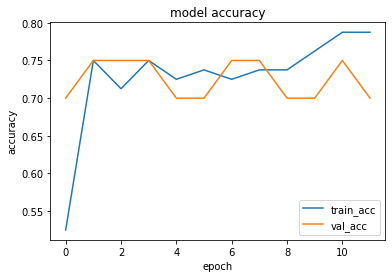

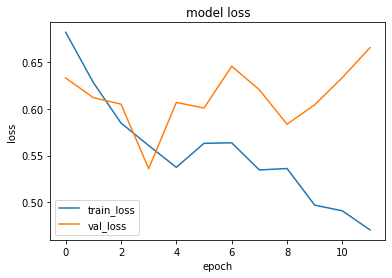

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.49705318]]


1it [00:00, 11491.24it/s]


prediction for video armflapping_3.mov is [[0.49421483]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_2.mov is [[0.5345297]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.46331754]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.44527763]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.44170645]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.7121 - accuracy: 0.4625 - precision_140: 0.4746 - recall_140: 0.7000 - val_loss: 0.6823 - val_accuracy: 0.5500 - val_precision_140: 0.5455 - val_recall_140: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6533 - accuracy: 0.6375 - precision_140: 0.6279 - recall_140: 0.6750 - val_loss: 0.6383 - val_accuracy: 0.6000 - val_precision_140: 0.5833 - val_recall_140: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5963 - accuracy: 0.7250 - precision_140: 0.6731 - recall_140: 0.8750 - val_loss: 0.5839 - val_accuracy: 0.6500 - val_precision_140: 0.6364 - val_recall_140: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.5976 - accuracy: 0.7000 - precision_140: 0.6739 - recall_140: 0.7750 - val_loss: 0.5787 - val_accuracy: 0.8000 - val_precision_140: 0.8750 - val_recall_140: 0.

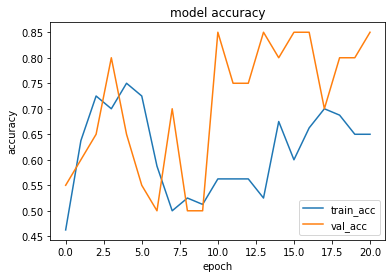

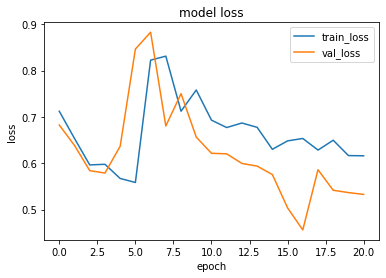

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.45146713]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.45881382]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.47684327]]


1it [00:00, 11650.84it/s]


prediction for video control_1.mov is [[0.4435324]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.44126347]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.4413091]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7016 - accuracy: 0.5125 - precision_141: 0.5135 - recall_141: 0.4750 - val_loss: 0.6925 - val_accuracy: 0.6500 - val_precision_141: 0.6364 - val_recall_141: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6233 - accuracy: 0.7250 - precision_141: 0.7143 - recall_141: 0.7500 - val_loss: 0.8137 - val_accuracy: 0.5000 - val_precision_141: 0.5000 - val_recall_141: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.5708 - accuracy: 0.6875 - precision_141: 0.6415 - recall_141: 0.8500 - val_loss: 0.6878 - val_accuracy: 0.6500 - val_precision_141: 0.7143 - val_recall_141: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5674 - accuracy: 0.7625 - precision_141: 0.8000 - recall_141: 0.7000 - val_loss: 0.6900 - val_accuracy: 0.6000 - val_precision_141: 0.6250 - val_recall_141: 0.5

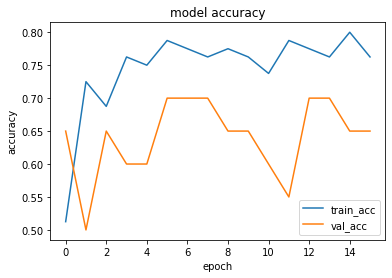

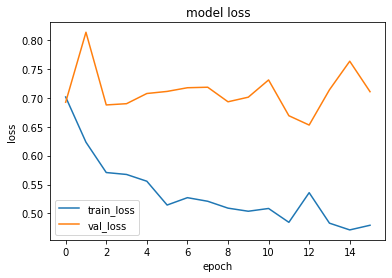

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.39846233]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.18147853]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.6368866]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.31503004]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.2859149]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.2873485]]
Epoch 1/75
3/3 [==============================] - 1s 136ms/step - loss: 0.7203 - accuracy: 0.4125 - precision_142: 0.4314 - recall_142: 0.5500 - val_loss: 0.6383 - val_accuracy: 0.6500 - val_precision_142: 0.8000 - val_recall_142: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6596 - accuracy: 0.6250 - precision_142: 0.7778 - recall_142: 0.3500 - val_loss: 0.5932 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6316 - accuracy: 0.7375 - precision_142: 0.7436 - recall_142: 0.7250 - val_loss: 0.5622 - val_accuracy: 0.7500 - val_precision_142: 0.6923 - val_recall_142: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5969 - accuracy: 0.6750 - precision_142: 0.6346 - recall_142: 0.8250 - val_loss: 0.5304 - val_accuracy: 0.7500 - val_precision_142: 0.7273 - val_recall_142: 0.8

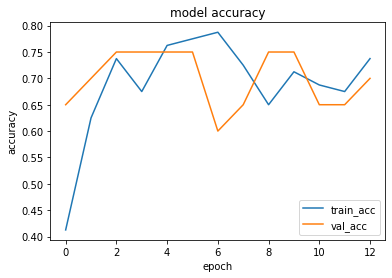

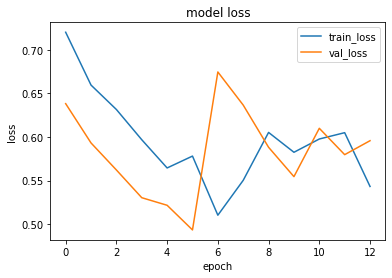

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.40051994]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5983199]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.53048265]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.35269648]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.352694]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.35429513]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7017 - accuracy: 0.5250 - precision_143: 0.5139 - recall_143: 0.9250 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6621 - accuracy: 0.6250 - precision_143: 0.7778 - recall_143: 0.3500 - val_loss: 0.6258 - val_accuracy: 0.7000 - val_precision_143: 0.7500 - val_recall_143: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6369 - accuracy: 0.7000 - precision_143: 0.6905 - recall_143: 0.7250 - val_loss: 0.6017 - val_accuracy: 0.7500 - val_precision_143: 0.7778 - val_recall_143: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6033 - accuracy: 0.7000 - precision_143: 0.6600 - recall_143: 0.8250 - val_loss: 0.5747 - val_accuracy: 0.7500 - val_precision_143: 0.7273 - val_recall

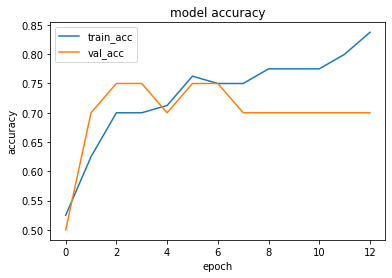

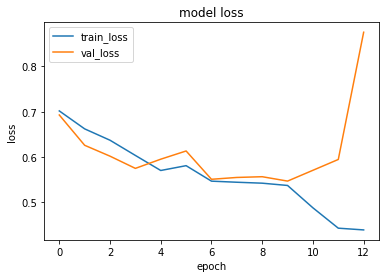

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.3961807]]


1it [00:00, 15087.42it/s]


prediction for video armflapping_3.mov is [[0.96167886]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.9622077]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.17197138]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.15007845]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.14650118]]


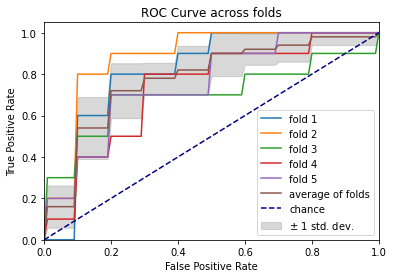

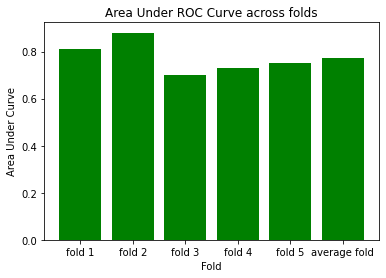

In [241]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6924 - accuracy: 0.4875 - precision_145: 0.4909 - recall_145: 0.6750 - val_loss: 0.6404 - val_accuracy: 0.7500 - val_precision_145: 0.7273 - val_recall_145: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6242 - accuracy: 0.7625 - precision_145: 0.7561 - recall_145: 0.7750 - val_loss: 0.6626 - val_accuracy: 0.6500 - val_precision_145: 0.6000 - val_recall_145: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6191 - accuracy: 0.7000 - precision_145: 0.6818 - recall_145: 0.7500 - val_loss: 0.6674 - val_accuracy: 0.6500 - val_precision_145: 0.6364 - val_recall_145: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5725 - accuracy: 0.7000 - precision_145: 0.7500 - recall_145: 0.6000 - val_loss: 0.6195 - val_accuracy: 0.6500 - val_precision_145: 0.6667 - val_recall_145: 0.6000
Epoch 5/75
3/3 [==============================] 

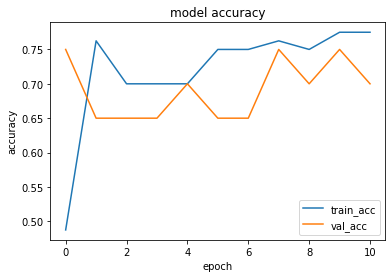

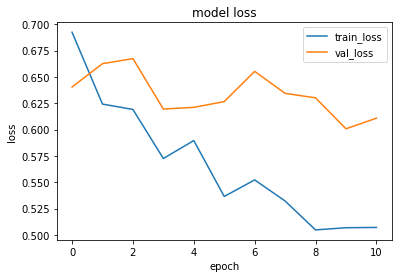

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.5183017]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.50337166]]


1it [00:00, 10106.76it/s]


prediction for video armflapping_2.mov is [[0.52893317]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.5015959]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.49470446]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.4946768]]
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.7087 - accuracy: 0.4250 - precision_146: 0.4348 - recall_146: 0.5000 - val_loss: 0.6626 - val_accuracy: 0.5000 - val_precision_146: 0.5000 - val_recall_146: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6509 - accuracy: 0.5875 - precision_146: 0.5507 - recall_146: 0.9500 - val_loss: 0.6159 - val_accuracy: 0.5500 - val_precision_146: 0.5333 - val_recall_146: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6051 - accuracy: 0.6625 - precision_146: 0.6032 - recall_146: 0.9500 - val_loss: 0.7615 - val_accuracy: 0.6000 - val_precision_146: 1.0000 - val_recall_146: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.7537 - accuracy: 0.5750 - precision_146: 0.8000 - recall_146: 0.2000 - val_loss: 0.6438 - val_accuracy: 0.6500 - val_precision_146: 0.8000 - val_recall_146: 0.4

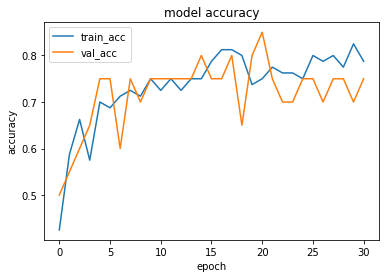

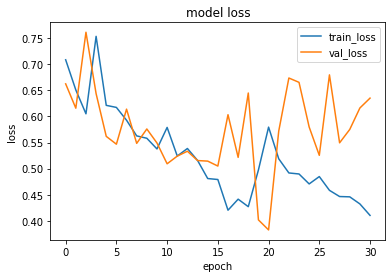

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.31821772]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5213814]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6783579]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.27697456]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.25716633]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.2579679]]
Epoch 1/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6847 - accuracy: 0.4375 - precision_147: 0.4576 - recall_147: 0.6750 - val_loss: 0.6971 - val_accuracy: 0.5500 - val_precision_147: 0.5333 - val_recall_147: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6332 - accuracy: 0.6250 - precision_147: 0.5833 - recall_147: 0.8750 - val_loss: 0.6976 - val_accuracy: 0.7500 - val_precision_147: 0.7778 - val_recall_147: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.5602 - accuracy: 0.7625 - precision_147: 0.7561 - recall_147: 0.7750 - val_loss: 0.7183 - val_accuracy: 0.6500 - val_precision_147: 0.6667 - val_recall_147: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.5443 - accuracy: 0.7250 - precision_147: 0.7250 - recall_147: 0.7250 - val_loss: 0.7911 - val_accuracy: 0.5500 - val_precision_147: 0.5556 - val_recall_147: 0.5

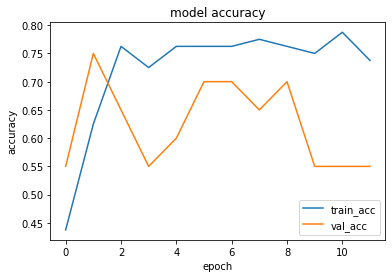

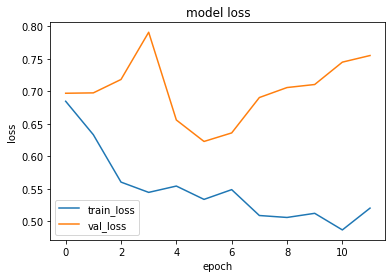

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.2661283]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.19490516]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.5516854]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.20616359]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.1819379]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.17953578]]
Epoch 1/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6998 - accuracy: 0.6625 - precision_148: 0.6857 - recall_148: 0.6000 - val_loss: 0.5826 - val_accuracy: 0.7000 - val_precision_148: 0.6667 - val_recall_148: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6176 - accuracy: 0.7500 - precision_148: 0.7778 - recall_148: 0.7000 - val_loss: 0.5426 - val_accuracy: 0.7000 - val_precision_148: 0.7000 - val_recall_148: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5749 - accuracy: 0.7500 - precision_148: 0.7632 - recall_148: 0.7250 - val_loss: 0.6031 - val_accuracy: 0.6500 - val_precision_148: 0.6154 - val_recall_148: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5431 - accuracy: 0.7375 - precision_148: 0.7209 - recall_148: 0.7750 - val_loss: 0.5218 - val_accuracy: 0.7500 - val_precision_148: 0.6923 - val_recall_148: 0.

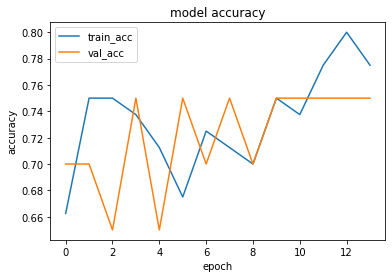

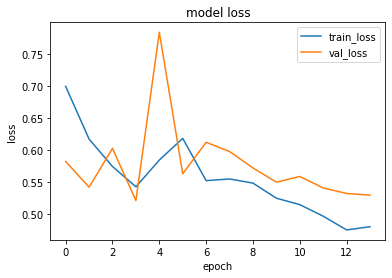

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.6361357]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.8149667]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.76498127]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.41142443]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.3056093]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.29209888]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7205 - accuracy: 0.3625 - precision_149: 0.4068 - recall_149: 0.6000 - val_loss: 0.6406 - val_accuracy: 0.8000 - val_precision_149: 0.8750 - val_recall_149: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6482 - accuracy: 0.7500 - precision_149: 0.7500 - recall_149: 0.7500 - val_loss: 0.6204 - val_accuracy: 0.6500 - val_precision_149: 1.0000 - val_recall_149: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6154 - accuracy: 0.7125 - precision_149: 0.7297 - recall_149: 0.6750 - val_loss: 0.5433 - val_accuracy: 0.7000 - val_precision_149: 0.7000 - val_recall_149: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6046 - accuracy: 0.7125 - precision_149: 0.6735 - recall_149: 0.8250 - val_loss: 0.6093 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.

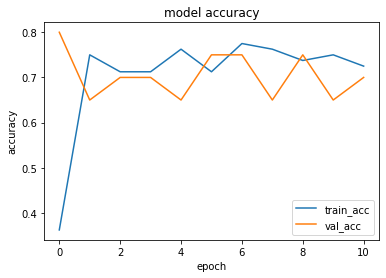

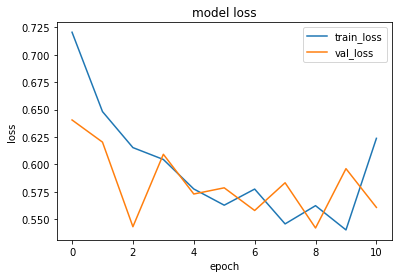

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.34613264]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_3.mov is [[0.3643378]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.57061696]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.29786634]]


1it [00:00, 12192.74it/s]


prediction for video control_2.mov is [[0.28812873]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.28744152]]


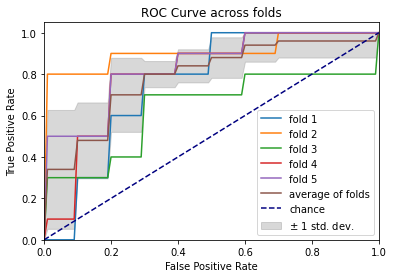

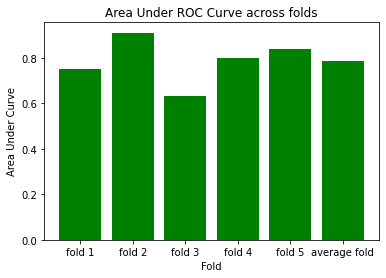

In [242]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6819 - accuracy: 0.5250 - precision_151: 0.5179 - recall_151: 0.7250 - val_loss: 0.7061 - val_accuracy: 0.6500 - val_precision_151: 0.6000 - val_recall_151: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6278 - accuracy: 0.6750 - precision_151: 0.6750 - recall_151: 0.6750 - val_loss: 0.6308 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5927 - accuracy: 0.6875 - precision_151: 0.6829 - recall_151: 0.7000 - val_loss: 0.7163 - val_accuracy: 0.7000 - val_precision_151: 0.6429 - val_recall_151: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6035 - accuracy: 0.6875 - precision_151: 0.7143 - recall_151: 0.6250 - val_loss: 0.7122 - val_accuracy: 0.6000 - val_precision_151: 0.6000 - val_recall_151: 0.6000
Epoch 5/75
3/3 [==============================] 

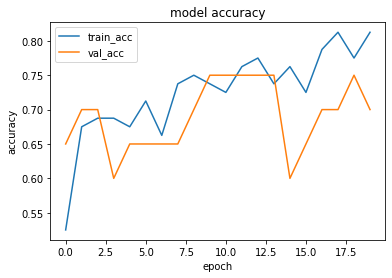

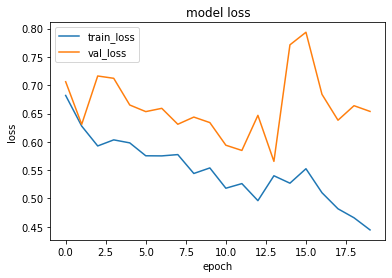

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.5119352]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.62036604]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.632873]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.37439576]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.32486582]]


1it [00:00, 14563.56it/s]


prediction for video control_3.mov is [[0.29009944]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6941 - accuracy: 0.5750 - precision_152: 0.6364 - recall_152: 0.3500 - val_loss: 0.6189 - val_accuracy: 0.5500 - val_precision_152: 0.5263 - val_recall_152: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6409 - accuracy: 0.5375 - precision_152: 0.5217 - recall_152: 0.9000 - val_loss: 0.5995 - val_accuracy: 0.7000 - val_precision_152: 0.7000 - val_recall_152: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5893 - accuracy: 0.7250 - precision_152: 0.7045 - recall_152: 0.7750 - val_loss: 0.5745 - val_accuracy: 0.8000 - val_precision_152: 0.8750 - val_recall_152: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5810 - accuracy: 0.7125 - precision_152: 0.7576 - recall_152: 0.6250 - val_loss: 0.5017 - val_accuracy: 0.8500 - val_precision_152: 0.8182 - val_recall_152: 0.

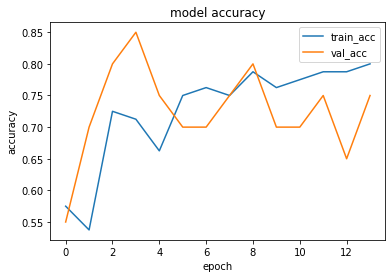

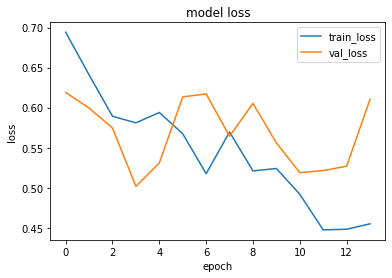

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.49533597]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.49930722]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.5632104]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.43910205]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.40357137]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.40106595]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6759 - accuracy: 0.4750 - precision_153: 0.4773 - recall_153: 0.5250 - val_loss: 0.8797 - val_accuracy: 0.5000 - val_precision_153: 0.5000 - val_recall_153: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.8570 - accuracy: 0.5125 - precision_153: 0.5065 - recall_153: 0.9750 - val_loss: 0.7036 - val_accuracy: 0.6500 - val_precision_153: 0.6364 - val_recall_153: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6291 - accuracy: 0.7250 - precision_153: 0.7045 - recall_153: 0.7750 - val_loss: 0.7033 - val_accuracy: 0.6500 - val_precision_153: 0.6667 - val_recall_153: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6035 - accuracy: 0.7375 - precision_153: 0.7436 - recall_153: 0.7250 - val_loss: 0.6944 - val_accuracy: 0.7500 - val_precision_153: 0.7778 - val_recall_153: 0.

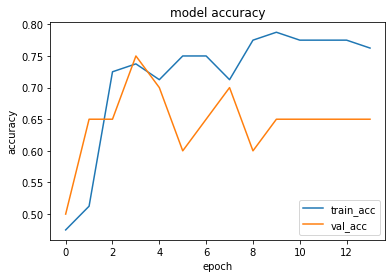

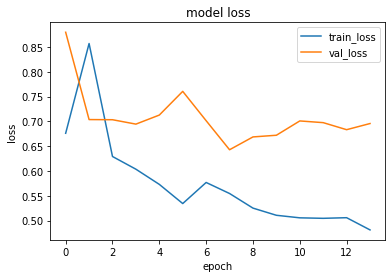

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.37736607]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.3155526]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_2.mov is [[0.46939063]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3022784]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.2851777]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.27731872]]
Epoch 1/75
3/3 [==============================] - 0s 151ms/step - loss: 0.7373 - accuracy: 0.4250 - precision_154: 0.3846 - recall_154: 0.2500 - val_loss: 0.6586 - val_accuracy: 0.7000 - val_precision_154: 0.6429 - val_recall_154: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6719 - accuracy: 0.6375 - precision_154: 0.5965 - recall_154: 0.8500 - val_loss: 0.6295 - val_accuracy: 0.7000 - val_precision_154: 0.6667 - val_recall_154: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6413 - accuracy: 0.6750 - precision_154: 0.6522 - recall_154: 0.7500 - val_loss: 0.5909 - val_accuracy: 0.7000 - val_precision_154: 0.7000 - val_recall_154: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6043 - accuracy: 0.7125 - precision_154: 0.7429 - recall_154: 0.6500 - val_loss: 0.5874 - val_accuracy: 0.7000 - val_precision_154: 0.6667 - val_recall_154: 0.

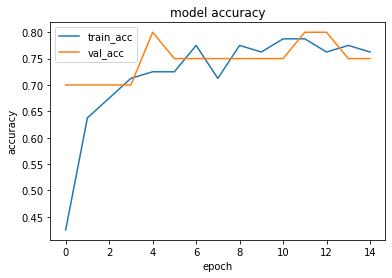

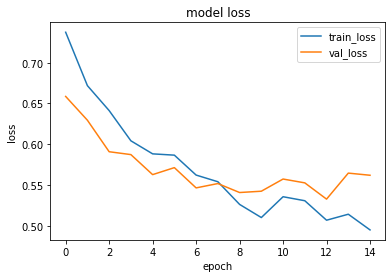

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.569326]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.76013994]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.77536434]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.2832477]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.23424041]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.22923064]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6798 - accuracy: 0.4500 - precision_155: 0.4677 - recall_155: 0.7250 - val_loss: 0.6340 - val_accuracy: 0.6500 - val_precision_155: 0.6000 - val_recall_155: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6473 - accuracy: 0.6500 - precision_155: 0.6034 - recall_155: 0.8750 - val_loss: 0.6180 - val_accuracy: 0.6000 - val_precision_155: 0.7500 - val_recall_155: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6408 - accuracy: 0.7250 - precision_155: 0.8000 - recall_155: 0.6000 - val_loss: 0.5742 - val_accuracy: 0.7000 - val_precision_155: 0.7000 - val_recall_155: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5851 - accuracy: 0.6875 - precision_155: 0.6471 - recall_155: 0.8250 - val_loss: 0.5609 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.

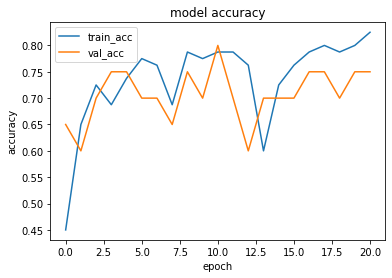

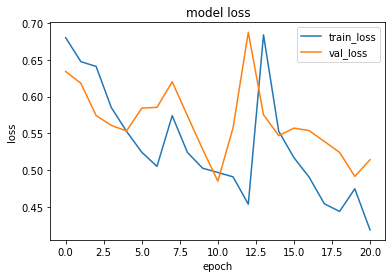

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.69137466]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.79007906]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.8400927]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.21051165]]


1it [00:00, 19878.22it/s]


prediction for video control_2.mov is [[0.19852859]]


1it [00:00, 12671.61it/s]


prediction for video control_3.mov is [[0.19719967]]


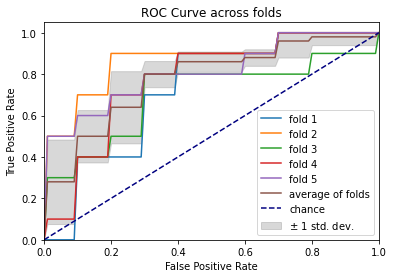

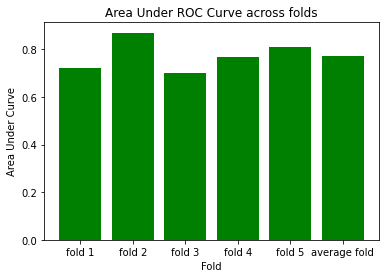

In [243]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6920 - accuracy: 0.6125 - precision_157: 0.6047 - recall_157: 0.6500 - val_loss: 0.7006 - val_accuracy: 0.6500 - val_precision_157: 0.6000 - val_recall_157: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6356 - accuracy: 0.6625 - precision_157: 0.7097 - recall_157: 0.5500 - val_loss: 0.6401 - val_accuracy: 0.7000 - val_precision_157: 0.7500 - val_recall_157: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6068 - accuracy: 0.7125 - precision_157: 0.7429 - recall_157: 0.6500 - val_loss: 0.6819 - val_accuracy: 0.6500 - val_precision_157: 0.6000 - val_recall_157: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.5993 - accuracy: 0.7000 - precision_157: 0.6600 - recall_157: 0.8250 - val_loss: 0.6287 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000
Epoch 5/75
3/3 [==============================] 

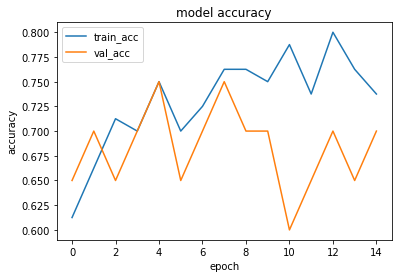

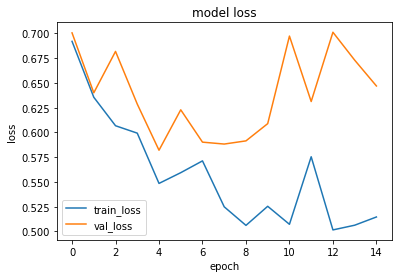

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.41576856]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.47174576]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.53746766]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.23795533]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.19862449]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.1905992]]
Epoch 1/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6849 - accuracy: 0.5125 - precision_158: 0.5122 - recall_158: 0.5250 - val_loss: 0.6537 - val_accuracy: 0.6000 - val_precision_158: 0.5714 - val_recall_158: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6268 - accuracy: 0.5875 - precision_158: 0.5538 - recall_158: 0.9000 - val_loss: 0.5806 - val_accuracy: 0.6000 - val_precision_158: 0.5625 - val_recall_158: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5799 - accuracy: 0.7125 - precision_158: 0.6735 - recall_158: 0.8250 - val_loss: 1.2359 - val_accuracy: 0.5000 - val_precision_158: 0.0000e+00 - val_recall_158: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.9233 - accuracy: 0.5375 - precision_158: 0.7143 - recall_158: 0.1250 - val_loss: 0.6121 - val_accuracy: 0.8000 - val_precision_158: 0.8750 - val_recall_

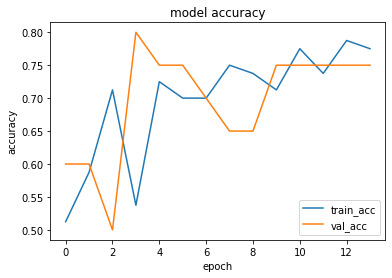

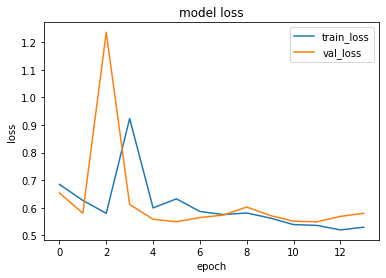

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.4853297]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.5013211]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.50148916]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.45256203]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.43306625]]


1it [00:00, 10538.45it/s]


prediction for video control_3.mov is [[0.43971297]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6901 - accuracy: 0.5375 - precision_159: 0.5294 - recall_159: 0.6750 - val_loss: 0.6954 - val_accuracy: 0.6000 - val_precision_159: 1.0000 - val_recall_159: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6008 - accuracy: 0.7375 - precision_159: 0.7879 - recall_159: 0.6500 - val_loss: 0.7289 - val_accuracy: 0.6500 - val_precision_159: 0.6154 - val_recall_159: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5920 - accuracy: 0.7125 - precision_159: 0.6735 - recall_159: 0.8250 - val_loss: 0.8587 - val_accuracy: 0.4500 - val_precision_159: 0.0000e+00 - val_recall_159: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6574 - accuracy: 0.6500 - precision_159: 0.7727 - recall_159: 0.4250 - val_loss: 0.6489 - val_accuracy: 0.6500 - val_precision_159: 0.6667 - val_recall

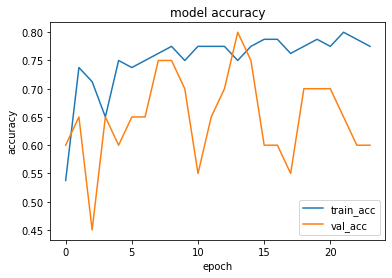

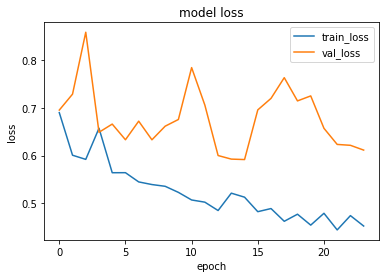

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.35954252]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.41566172]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.525117]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.33384788]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.3277234]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.32715365]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7372 - accuracy: 0.5000 - precision_160: 0.5000 - recall_160: 0.1750 - val_loss: 0.6755 - val_accuracy: 0.5000 - val_precision_160: 0.5000 - val_recall_160: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6793 - accuracy: 0.5250 - precision_160: 0.5132 - recall_160: 0.9750 - val_loss: 0.6547 - val_accuracy: 0.6000 - val_precision_160: 0.5714 - val_recall_160: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6506 - accuracy: 0.6875 - precision_160: 0.6744 - recall_160: 0.7250 - val_loss: 0.6252 - val_accuracy: 0.7000 - val_precision_160: 0.7000 - val_recall_160: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6150 - accuracy: 0.6875 - precision_160: 0.7273 - recall_160: 0.6000 - val_loss: 0.5854 - val_accuracy: 0.7500 - val_precision_160: 0.7273 - val_recall_160: 0.

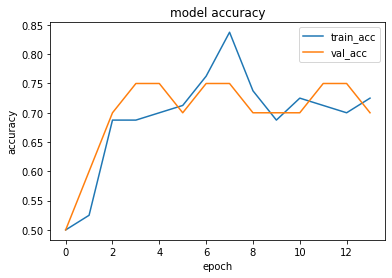

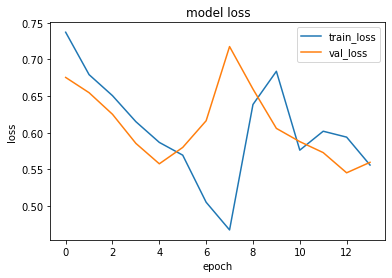

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.24428272]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.72449416]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.6679808]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.18295905]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.1822108]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.193508]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7582 - accuracy: 0.4375 - precision_161: 0.4615 - recall_161: 0.7500 - val_loss: 0.6705 - val_accuracy: 0.6500 - val_precision_161: 0.6667 - val_recall_161: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6653 - accuracy: 0.6625 - precision_161: 0.7097 - recall_161: 0.5500 - val_loss: 0.6608 - val_accuracy: 0.6000 - val_precision_161: 1.0000 - val_recall_161: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6539 - accuracy: 0.6625 - precision_161: 0.6970 - recall_161: 0.5750 - val_loss: 0.6041 - val_accuracy: 0.6000 - val_precision_161: 0.5714 - val_recall_161: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6068 - accuracy: 0.6875 - precision_161: 0.6364 - recall_161: 0.8750 - val_loss: 0.6139 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.50

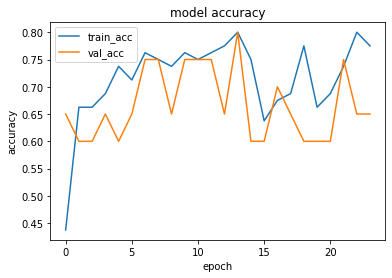

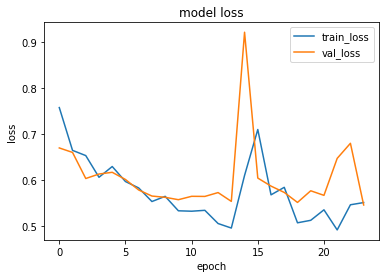

1it [00:00, 13025.79it/s]


prediction for video armflapping_1.mov is [[0.38896638]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_3.mov is [[0.38585335]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.52963626]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.2085396]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.21355852]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.25608313]]


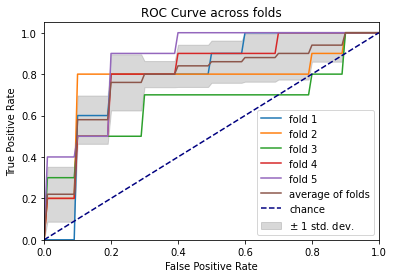

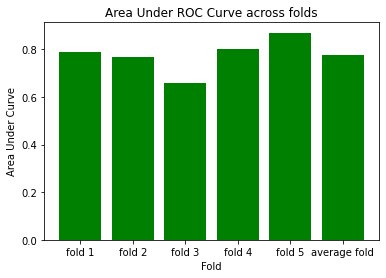

In [244]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7184 - accuracy: 0.5375 - precision_163: 0.5517 - recall_163: 0.4000 - val_loss: 0.7530 - val_accuracy: 0.5000 - val_precision_163: 0.5000 - val_recall_163: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7185 - accuracy: 0.5000 - precision_163: 0.5000 - recall_163: 0.9500 - val_loss: 0.7486 - val_accuracy: 0.6000 - val_precision_163: 0.5714 - val_recall_163: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6422 - accuracy: 0.7375 - precision_163: 0.7317 - recall_163: 0.7500 - val_loss: 0.7006 - val_accuracy: 0.6500 - val_precision_163: 0.6364 - val_recall_163: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6352 - accuracy: 0.6625 - precision_163: 0.6970 - recall_163: 0.5750 - val_loss: 0.6868 - val_accuracy: 0.6500 - val_precision_163: 0.6364 - val_recall_163: 0.7000
Epoch 5/75
3/3 [==============================] 

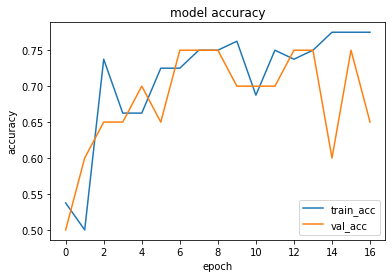

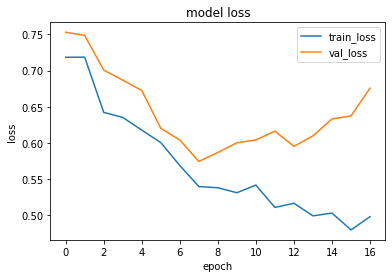

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.4368584]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.53248626]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.66327924]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.21966064]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.17756972]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.17706627]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6736 - accuracy: 0.5000 - precision_164: 0.5000 - recall_164: 0.5250 - val_loss: 0.6588 - val_accuracy: 0.5500 - val_precision_164: 0.5333 - val_recall_164: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6607 - accuracy: 0.5625 - precision_164: 0.5362 - recall_164: 0.9250 - val_loss: 0.5975 - val_accuracy: 0.6500 - val_precision_164: 0.6154 - val_recall_164: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6069 - accuracy: 0.6625 - precision_164: 0.6140 - recall_164: 0.8750 - val_loss: 0.6867 - val_accuracy: 0.8000 - val_precision_164: 0.8750 - val_recall_164: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5747 - accuracy: 0.7250 - precision_164: 0.7812 - recall_164: 0.6250 - val_loss: 0.7794 - val_accuracy: 0.7000 - val_precision_164: 0.8333 - val_recall_164: 0.

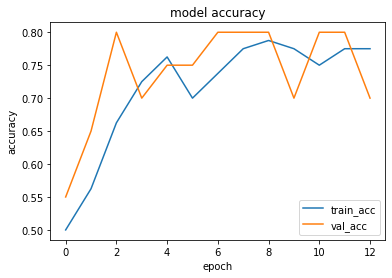

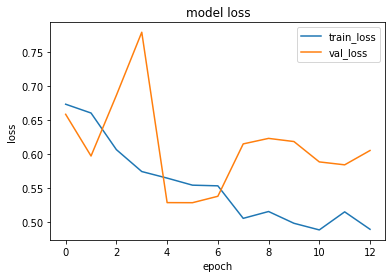

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.5177295]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.53443754]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.54267585]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.48885196]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.4713966]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.47376132]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6934 - accuracy: 0.5375 - precision_165: 0.5600 - recall_165: 0.3500 - val_loss: 0.6917 - val_accuracy: 0.5000 - val_precision_165: 0.5000 - val_recall_165: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6393 - accuracy: 0.5875 - precision_165: 0.5493 - recall_165: 0.9750 - val_loss: 0.6991 - val_accuracy: 0.7000 - val_precision_165: 0.6667 - val_recall_165: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5985 - accuracy: 0.6250 - precision_165: 0.6136 - recall_165: 0.6750 - val_loss: 0.7113 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.5861 - accuracy: 0.7000 - precision_165: 0.6667 - recall_165: 0.8000 - val_loss: 0.6789 - val_accuracy: 0.7000 - val_precision_165: 0.6667 - val_recall_165: 0.

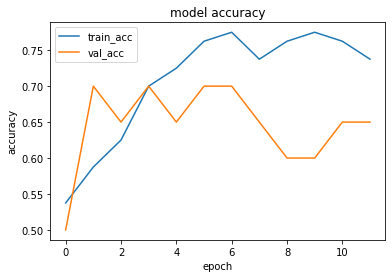

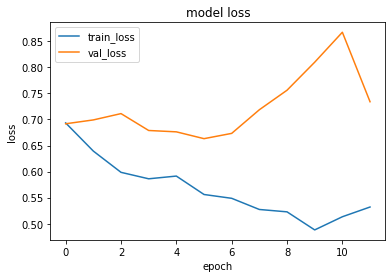

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.42120498]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.49155298]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.66690373]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.31933814]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.20999068]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.2918614]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7421 - accuracy: 0.4375 - precision_166: 0.4194 - recall_166: 0.3250 - val_loss: 0.6512 - val_accuracy: 0.7000 - val_precision_166: 0.6429 - val_recall_166: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6691 - accuracy: 0.6625 - precision_166: 0.6066 - recall_166: 0.9250 - val_loss: 0.6523 - val_accuracy: 0.7000 - val_precision_166: 0.6429 - val_recall_166: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6486 - accuracy: 0.6750 - precision_166: 0.6296 - recall_166: 0.8500 - val_loss: 0.6028 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6506 - accuracy: 0.6250 - precision_166: 0.7273 - recall_166: 0.4000 - val_loss: 0.5790 - val_accuracy: 0.8000 - val_precision_166: 0.8000 - val_recall_166: 0.8

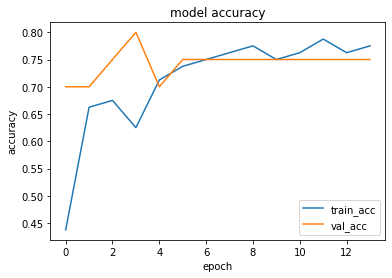

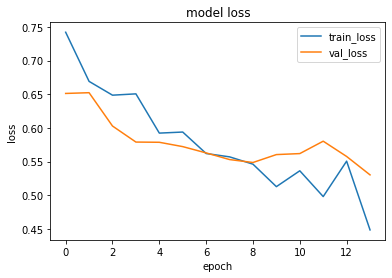

1it [00:00, 11748.75it/s]


prediction for video armflapping_1.mov is [[0.59213847]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.85038674]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.8037314]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.2913076]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.25223434]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.24791014]]
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.7105 - accuracy: 0.4375 - precision_167: 0.4000 - recall_167: 0.2500 - val_loss: 0.6433 - val_accuracy: 0.8000 - val_precision_167: 0.8000 - val_recall_167: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6422 - accuracy: 0.7000 - precision_167: 0.6739 - recall_167: 0.7750 - val_loss: 0.6115 - val_accuracy: 0.6500 - val_precision_167: 0.5882 - val_recall_167: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6167 - accuracy: 0.6750 - precision_167: 0.6400 - recall_167: 0.8000 - val_loss: 0.5799 - val_accuracy: 0.6500 - val_precision_167: 0.7143 - val_recall_167: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6055 - accuracy: 0.7250 - precision_167: 0.7647 - recall_167: 0.6500 - val_loss: 0.5840 - val_accuracy: 0.6500 - val_precision_167: 0.7143 - val_recall_167: 0.

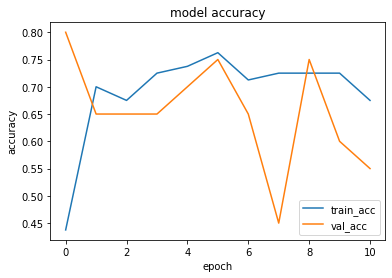

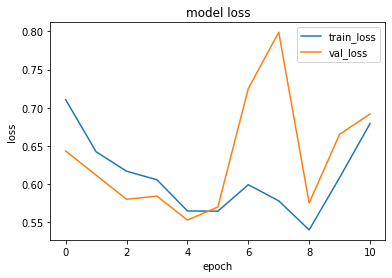

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.48395467]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.61086726]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5842385]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.4633092]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.2915306]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.4655409]]


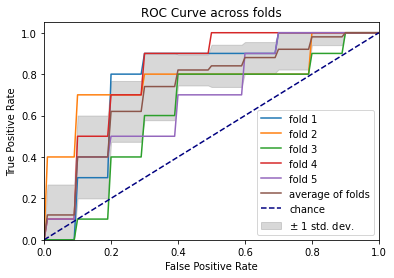

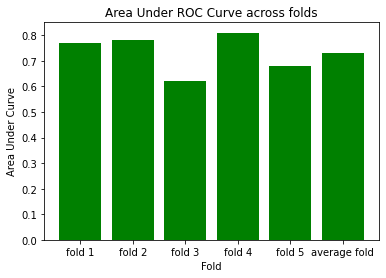

In [245]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6699 - accuracy: 0.6375 - precision_169: 0.6222 - recall_169: 0.7000 - val_loss: 0.6269 - val_accuracy: 0.6000 - val_precision_169: 0.5556 - val_recall_169: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6047 - accuracy: 0.6250 - precision_169: 0.5862 - recall_169: 0.8500 - val_loss: 0.7005 - val_accuracy: 0.6500 - val_precision_169: 0.6154 - val_recall_169: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5937 - accuracy: 0.7250 - precision_169: 0.7368 - recall_169: 0.7000 - val_loss: 0.6673 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5704 - accuracy: 0.7125 - precision_169: 0.7179 - recall_169: 0.7000 - val_loss: 0.6066 - val_accuracy: 0.7500 - val_precision_169: 0.6923 - val_recall_169: 0.9000
Epoch 5/75
3/3 [==============================] 

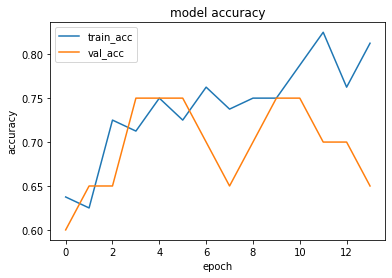

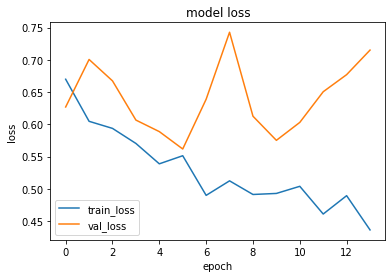

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.49159864]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.6216289]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.64285153]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.39012486]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.35380825]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.34214312]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7236 - accuracy: 0.4750 - precision_170: 0.4583 - recall_170: 0.2750 - val_loss: 0.6403 - val_accuracy: 0.5500 - val_precision_170: 0.5263 - val_recall_170: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6851 - accuracy: 0.5250 - precision_170: 0.5128 - recall_170: 1.0000 - val_loss: 0.6127 - val_accuracy: 0.7000 - val_precision_170: 0.6429 - val_recall_170: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6751 - accuracy: 0.6500 - precision_170: 0.6200 - recall_170: 0.7750 - val_loss: 0.6156 - val_accuracy: 0.8500 - val_precision_170: 0.8889 - val_recall_170: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6386 - accuracy: 0.7000 - precision_170: 0.7105 - recall_170: 0.6750 - val_loss: 0.5722 - val_accuracy: 0.8500 - val_precision_170: 0.8182 - val_recall_170: 0.

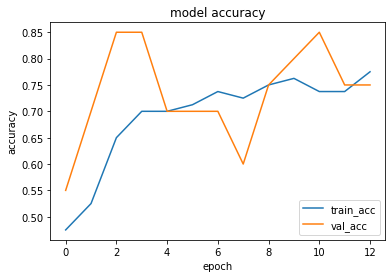

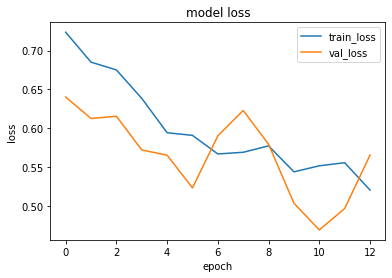

1it [00:00, 9177.91it/s]


prediction for video armflapping_1.mov is [[0.48036402]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.44624808]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5021429]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.44937938]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.43126675]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.42333308]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6802 - accuracy: 0.4750 - precision_171: 0.4815 - recall_171: 0.6500 - val_loss: 0.8684 - val_accuracy: 0.5000 - val_precision_171: 0.0000e+00 - val_recall_171: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7107 - accuracy: 0.6000 - precision_171: 0.6429 - recall_171: 0.4500 - val_loss: 0.7071 - val_accuracy: 0.4500 - val_precision_171: 0.4737 - val_recall_171: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6288 - accuracy: 0.5625 - precision_171: 0.5342 - recall_171: 0.9750 - val_loss: 0.7142 - val_accuracy: 0.4500 - val_precision_171: 0.4737 - val_recall_171: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6242 - accuracy: 0.6250 - precision_171: 0.5833 - recall_171: 0.8750 - val_loss: 0.7058 - val_accuracy: 0.7000 - val_precision_171: 0.7000 - val_recall

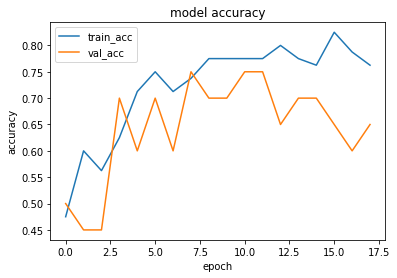

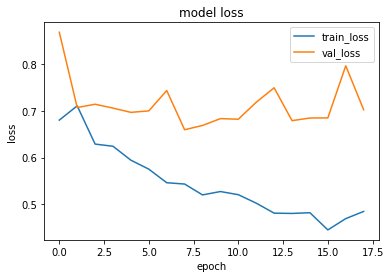

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.32757968]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.30439204]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_2.mov is [[0.50695384]]


1it [00:00, 12018.06it/s]


prediction for video control_1.mov is [[0.2697076]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.2495856]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.24653584]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7144 - accuracy: 0.5000 - precision_172: 0.5000 - recall_172: 0.2750 - val_loss: 0.6655 - val_accuracy: 0.5500 - val_precision_172: 0.5263 - val_recall_172: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6657 - accuracy: 0.6000 - precision_172: 0.5556 - recall_172: 1.0000 - val_loss: 0.6129 - val_accuracy: 0.7500 - val_precision_172: 0.7273 - val_recall_172: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6291 - accuracy: 0.7000 - precision_172: 0.6739 - recall_172: 0.7750 - val_loss: 0.5727 - val_accuracy: 0.7500 - val_precision_172: 0.6923 - val_recall_172: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6028 - accuracy: 0.6625 - precision_172: 0.6512 - recall_172: 0.7000 - val_loss: 0.5600 - val_accuracy: 0.8000 - val_precision_172: 0.8000 - val_recall_172: 0.

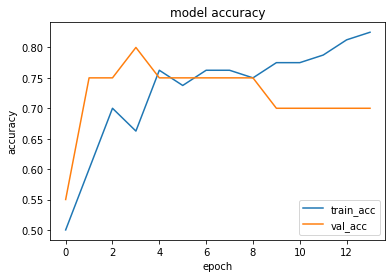

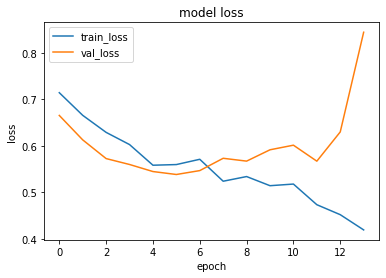

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.74335444]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.7749541]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.7836789]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.20634061]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.14814073]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.14682204]]
Epoch 1/75
3/3 [==============================] - 1s 196ms/step - loss: 0.7353 - accuracy: 0.5000 - precision_173: 0.5000 - recall_173: 0.1750 - val_loss: 0.6578 - val_accuracy: 0.5500 - val_precision_173: 0.5263 - val_recall_173: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6756 - accuracy: 0.5125 - precision_173: 0.5063 - recall_173: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.8000 - val_precision_173: 0.8000 - val_recall_173: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6434 - accuracy: 0.6875 - precision_173: 0.6531 - recall_173: 0.8000 - val_loss: 0.6044 - val_accuracy: 0.7000 - val_precision_173: 0.7500 - val_recall_173: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6084 - accuracy: 0.7250 - precision_173: 0.6875 - recall_173: 0.8250 - val_loss: 0.6945 - val_accuracy: 0.6000 - val_precision_173: 0.5556 - val_recall_173: 1.

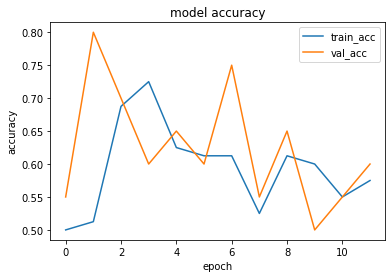

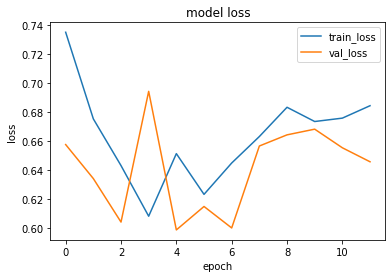

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.41445202]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.48841906]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.4776261]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.39802617]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.3948412]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.39404267]]


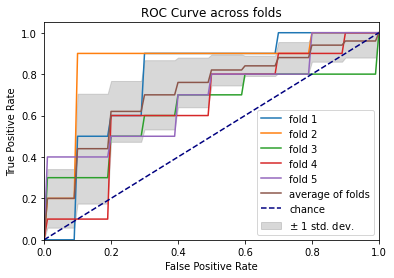

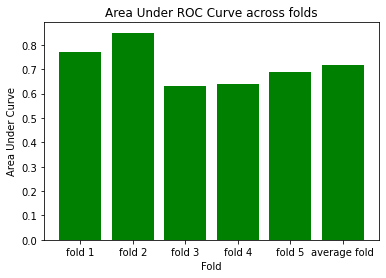

In [246]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6877 - accuracy: 0.5125 - precision_175: 0.5091 - recall_175: 0.7000 - val_loss: 0.7769 - val_accuracy: 0.5000 - val_precision_175: 0.5000 - val_recall_175: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6284 - accuracy: 0.6625 - precision_175: 0.6226 - recall_175: 0.8250 - val_loss: 0.6492 - val_accuracy: 0.6000 - val_precision_175: 0.6667 - val_recall_175: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6041 - accuracy: 0.7000 - precision_175: 0.7667 - recall_175: 0.5750 - val_loss: 0.6565 - val_accuracy: 0.6500 - val_precision_175: 0.6000 - val_recall_175: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5965 - accuracy: 0.7375 - precision_175: 0.7111 - recall_175: 0.8000 - val_loss: 0.6906 - val_accuracy: 0.7000 - val_precision_175: 0.6429 - val_recall_175: 0.9000
Epoch 5/75
3/3 [==============================] 

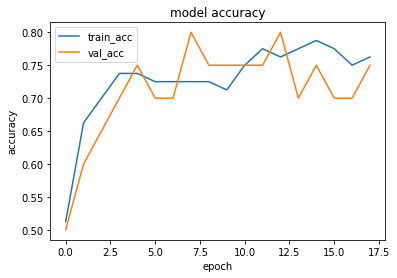

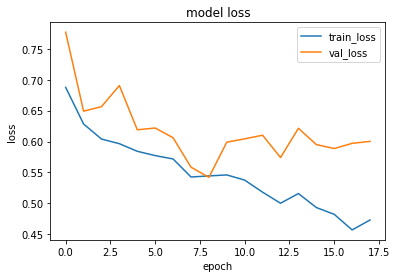

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.4304359]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5502516]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.61393046]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.2452125]]


1it [00:00, 18315.74it/s]


prediction for video control_2.mov is [[0.2211788]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.20850116]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6798 - accuracy: 0.6250 - precision_176: 0.5833 - recall_176: 0.8750 - val_loss: 0.8879 - val_accuracy: 0.5000 - val_precision_176: 0.0000e+00 - val_recall_176: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7144 - accuracy: 0.4875 - precision_176: 0.3333 - recall_176: 0.0250 - val_loss: 0.6485 - val_accuracy: 0.7000 - val_precision_176: 0.7500 - val_recall_176: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6520 - accuracy: 0.6375 - precision_176: 0.6222 - recall_176: 0.7000 - val_loss: 0.5989 - val_accuracy: 0.7000 - val_precision_176: 0.6429 - val_recall_176: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6624 - accuracy: 0.6375 - precision_176: 0.5932 - recall_176: 0.8750 - val_loss: 0.5796 - val_accuracy: 0.8500 - val_precision_176: 0.8182 - val_recall

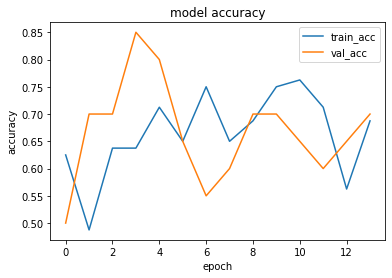

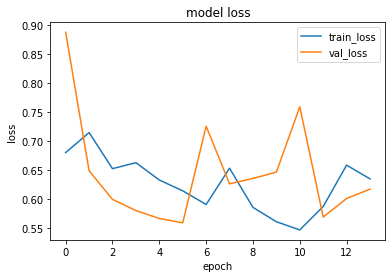

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.5036381]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.5520792]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5480587]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.48514828]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.47559643]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.47472]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6510 - accuracy: 0.5250 - precision_177: 0.5238 - recall_177: 0.5500 - val_loss: 0.7968 - val_accuracy: 0.5500 - val_precision_177: 0.5333 - val_recall_177: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.8358 - accuracy: 0.6375 - precision_177: 0.5902 - recall_177: 0.9000 - val_loss: 0.6789 - val_accuracy: 0.6500 - val_precision_177: 0.6667 - val_recall_177: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6614 - accuracy: 0.6000 - precision_177: 0.6053 - recall_177: 0.5750 - val_loss: 0.6867 - val_accuracy: 0.6500 - val_precision_177: 1.0000 - val_recall_177: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6288 - accuracy: 0.6375 - precision_177: 0.7895 - recall_177: 0.3750 - val_loss: 0.6608 - val_accuracy: 0.5500 - val_precision_177: 0.5714 - val_recall_177: 0.400

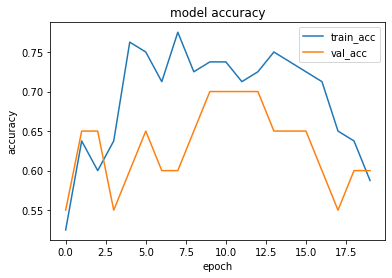

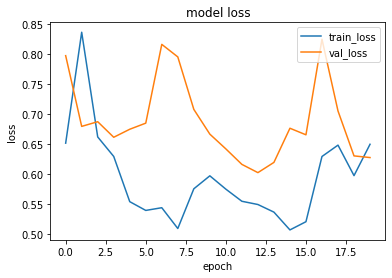

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.45705888]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.40354747]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.4540307]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.45283556]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.4510133]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.45073617]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6781 - accuracy: 0.5375 - precision_178: 0.5254 - recall_178: 0.7750 - val_loss: 0.5883 - val_accuracy: 0.7000 - val_precision_178: 0.6429 - val_recall_178: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6266 - accuracy: 0.7250 - precision_178: 0.7143 - recall_178: 0.7500 - val_loss: 0.5411 - val_accuracy: 0.7500 - val_precision_178: 0.6923 - val_recall_178: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6916 - accuracy: 0.6500 - precision_178: 0.6111 - recall_178: 0.8250 - val_loss: 0.5558 - val_accuracy: 0.7500 - val_precision_178: 0.7273 - val_recall_178: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6054 - accuracy: 0.7500 - precision_178: 0.7778 - recall_178: 0.7000 - val_loss: 0.5580 - val_accuracy: 0.7500 - val_precision_178: 0.7273 - val_recall_178: 0.

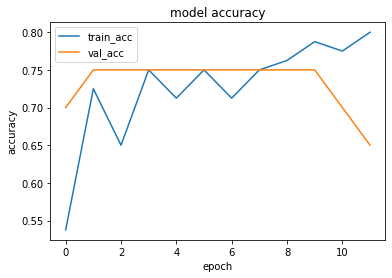

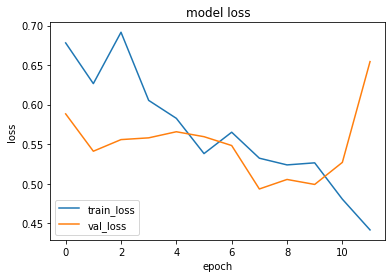

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.3980477]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.6342753]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.7297976]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.3483838]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.26000404]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.28018823]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6746 - accuracy: 0.6375 - precision_179: 0.6341 - recall_179: 0.6500 - val_loss: 0.5723 - val_accuracy: 0.7500 - val_precision_179: 0.7273 - val_recall_179: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6804 - accuracy: 0.6375 - precision_179: 0.5902 - recall_179: 0.9000 - val_loss: 0.5947 - val_accuracy: 0.7000 - val_precision_179: 0.8333 - val_recall_179: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6159 - accuracy: 0.7000 - precision_179: 0.7857 - recall_179: 0.5500 - val_loss: 0.6143 - val_accuracy: 0.6000 - val_precision_179: 0.7500 - val_recall_179: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.5884 - accuracy: 0.7000 - precision_179: 0.7667 - recall_179: 0.5750 - val_loss: 0.5780 - val_accuracy: 0.6500 - val_precision_179: 0.7143 - val_recall_179: 0.

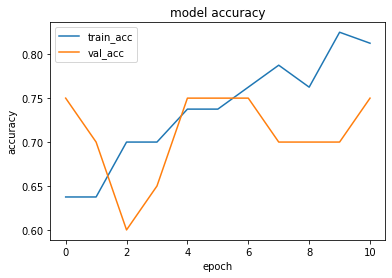

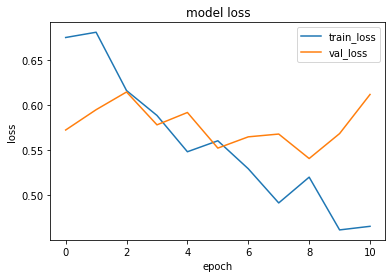

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.5667913]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.7611847]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.80348575]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.23717451]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.22739571]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.19310144]]


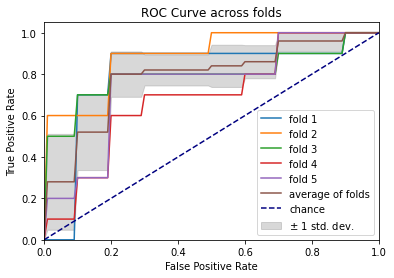

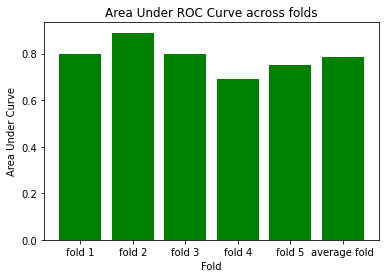

In [247]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6611 - accuracy: 0.5875 - precision_181: 0.5854 - recall_181: 0.6000 - val_loss: 0.7174 - val_accuracy: 0.6500 - val_precision_181: 0.6000 - val_recall_181: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6318 - accuracy: 0.7250 - precision_181: 0.6957 - recall_181: 0.8000 - val_loss: 0.6942 - val_accuracy: 0.6000 - val_precision_181: 0.7500 - val_recall_181: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6218 - accuracy: 0.6750 - precision_181: 0.8182 - recall_181: 0.4500 - val_loss: 0.7000 - val_accuracy: 0.6500 - val_precision_181: 0.6364 - val_recall_181: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5950 - accuracy: 0.7250 - precision_181: 0.7250 - recall_181: 0.7250 - val_loss: 0.6842 - val_accuracy: 0.7000 - val_precision_181: 0.6429 - val_recall_181: 0.9000
Epoch 5/75
3/3 [==============================] 

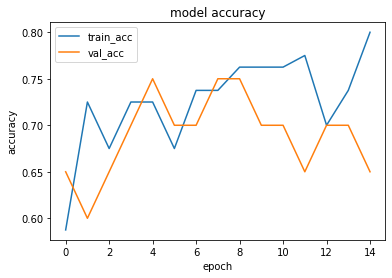

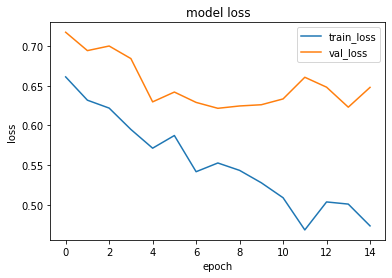

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.34196138]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5665014]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.59809005]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.16774595]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.15117696]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.15777001]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7260 - accuracy: 0.5500 - precision_182: 0.5476 - recall_182: 0.5750 - val_loss: 0.6372 - val_accuracy: 0.6500 - val_precision_182: 0.6000 - val_recall_182: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6614 - accuracy: 0.6625 - precision_182: 0.6327 - recall_182: 0.7750 - val_loss: 0.6204 - val_accuracy: 0.8000 - val_precision_182: 0.8000 - val_recall_182: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6477 - accuracy: 0.6750 - precision_182: 0.6842 - recall_182: 0.6500 - val_loss: 0.5794 - val_accuracy: 0.8000 - val_precision_182: 0.8000 - val_recall_182: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6189 - accuracy: 0.6875 - precision_182: 0.6596 - recall_182: 0.7750 - val_loss: 0.5306 - val_accuracy: 0.7500 - val_precision_182: 0.7273 - val_recall_182: 0.

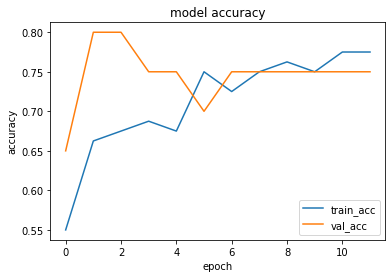

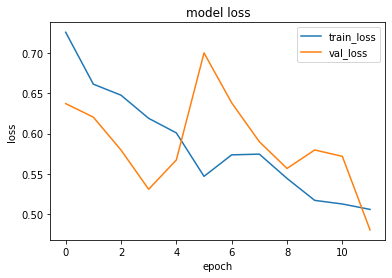

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.49893397]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.4481915]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.50827396]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.47915626]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.4661361]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.46495116]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6853 - accuracy: 0.4750 - precision_183: 0.4800 - recall_183: 0.6000 - val_loss: 0.6886 - val_accuracy: 0.5500 - val_precision_183: 0.5294 - val_recall_183: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6093 - accuracy: 0.5875 - precision_183: 0.5522 - recall_183: 0.9250 - val_loss: 0.7125 - val_accuracy: 0.6500 - val_precision_183: 0.6154 - val_recall_183: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5975 - accuracy: 0.7250 - precision_183: 0.7143 - recall_183: 0.7500 - val_loss: 0.6918 - val_accuracy: 0.6000 - val_precision_183: 0.6667 - val_recall_183: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5648 - accuracy: 0.7375 - precision_183: 0.7714 - recall_183: 0.6750 - val_loss: 0.6462 - val_accuracy: 0.6500 - val_precision_183: 0.6364 - val_recall_183: 0.

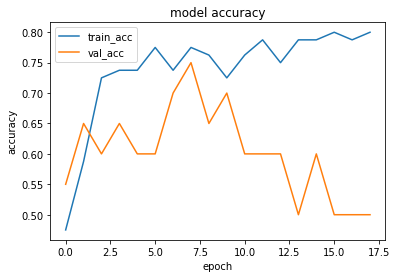

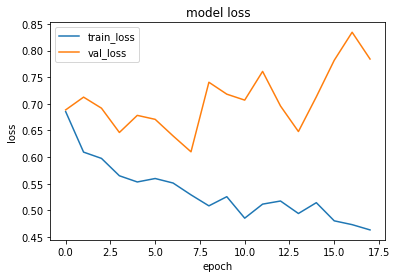

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.29372948]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.1910108]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6649468]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.26949933]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.2569484]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.25881547]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7328 - accuracy: 0.5500 - precision_184: 0.5556 - recall_184: 0.5000 - val_loss: 0.6543 - val_accuracy: 0.6000 - val_precision_184: 0.5556 - val_recall_184: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6756 - accuracy: 0.5500 - precision_184: 0.5286 - recall_184: 0.9250 - val_loss: 0.6410 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6494 - accuracy: 0.7250 - precision_184: 0.6875 - recall_184: 0.8250 - val_loss: 0.6074 - val_accuracy: 0.6500 - val_precision_184: 0.6154 - val_recall_184: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6290 - accuracy: 0.7000 - precision_184: 0.6600 - recall_184: 0.8250 - val_loss: 0.5704 - val_accuracy: 0.7000 - val_precision_184: 0.7000 - val_recall_184: 0.

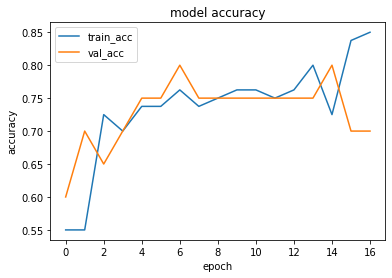

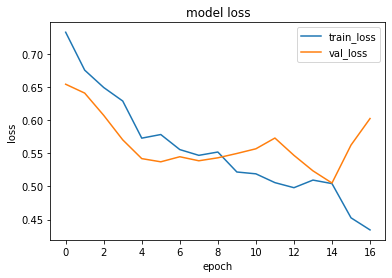

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.4016436]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.54524344]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.73861027]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.3278293]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.21312526]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.26708078]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7364 - accuracy: 0.4625 - precision_185: 0.4286 - recall_185: 0.2250 - val_loss: 0.6488 - val_accuracy: 0.5500 - val_precision_185: 0.5263 - val_recall_185: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6808 - accuracy: 0.5375 - precision_185: 0.5195 - recall_185: 1.0000 - val_loss: 0.6279 - val_accuracy: 0.7500 - val_precision_185: 0.7273 - val_recall_185: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6388 - accuracy: 0.7000 - precision_185: 0.6600 - recall_185: 0.8250 - val_loss: 0.6303 - val_accuracy: 0.6500 - val_precision_185: 0.7143 - val_recall_185: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6505 - accuracy: 0.6500 - precision_185: 0.6579 - recall_185: 0.6250 - val_loss: 0.6022 - val_accuracy: 0.6500 - val_precision_185: 0.7143 - val_recall_185: 0.

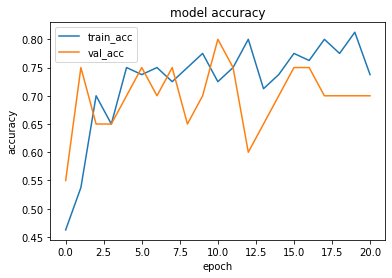

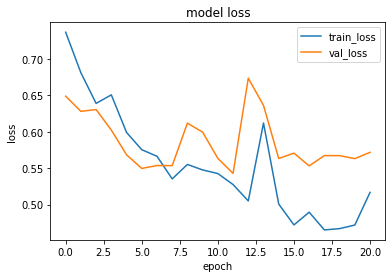

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.5910981]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.75671947]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.71206707]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.20328477]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.16000953]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.17492971]]


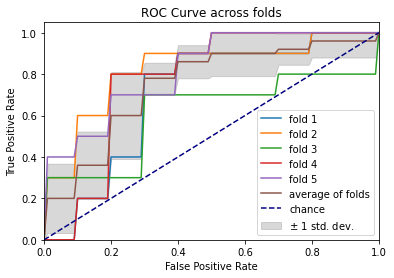

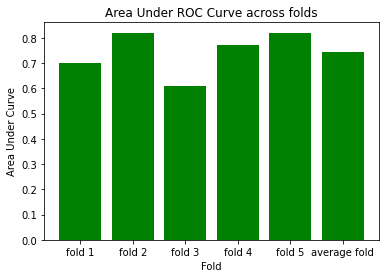

In [248]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

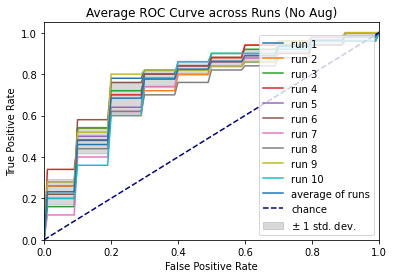

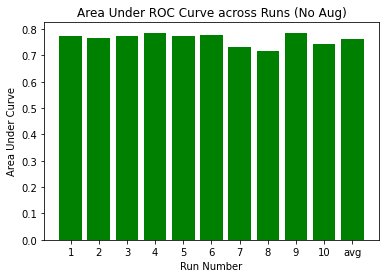

In [249]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [250]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7629999999999999, 0.021713004063338297)

In [2]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [3]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [4]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [5]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [6]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [7]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

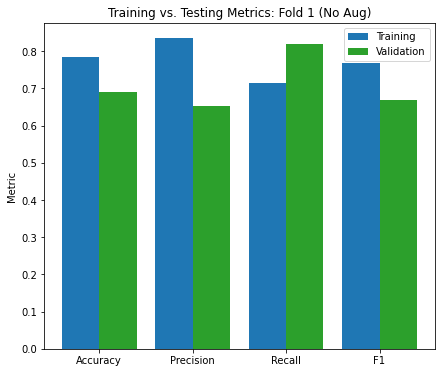

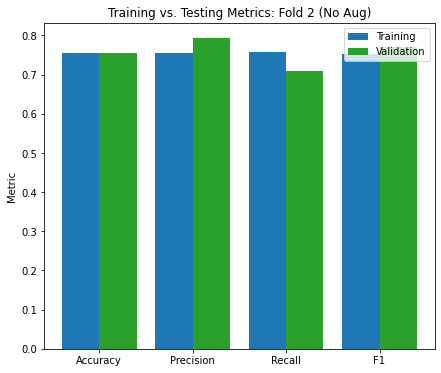

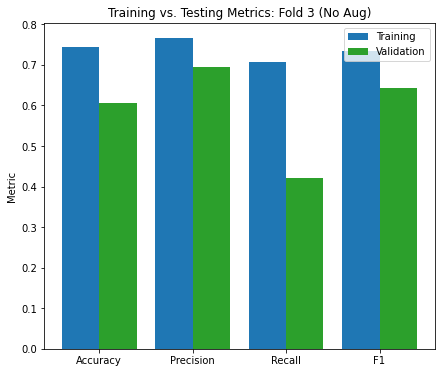

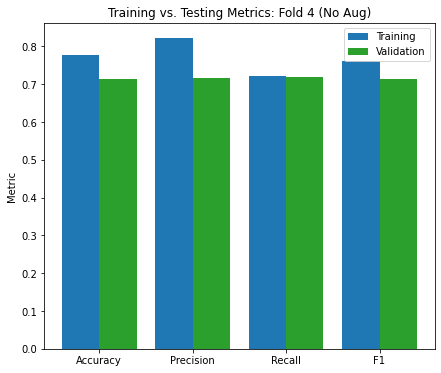

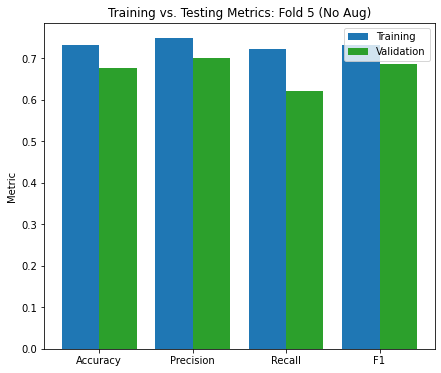

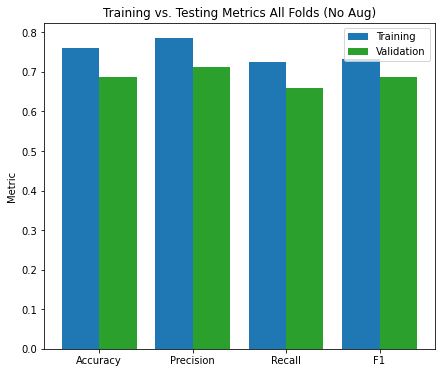

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()